# SPICE uncertainties

## Introduction

A value in a SPICE data cube is not the true value of the signal, it is a realization of a random variable, corresponding to the average signal and to a random noise. The width of the distribution of the noise contributes to the uncertainties on the signal. There are other sources of uncertainties, like systematic calibration uncertainties (not considered here).

To fit any model to SPICE data correctly, we need to know the uncertainties on the data. This applies to line fitting, but also to any diagnostics.

Signal and uncertainties modelling is presented in Sec. 8.7 of the Scientific Performance Report [SPICE-RAL-RP-0002](https://spice-wiki.ias.u-psud.fr/lib/exe/fetch.php/documents:internal:spice-ral-rp-0002_iss_10.0_spice_scientific_performance_report.pdf). Another reference will be App. B of Huang, Teriaca et al. (2023).

## Notations

When 2 notations are given, the first is from SPICE-RAL-RP-0002, the second is from Huang et al. Other notations can also be my own. Units are given as examples, equivalent units can also be used.

* $(θ_x, θ_y, λ, t)$: solar helioprojective coordinates [arcsec], wavelength [nm], and time
* $(x, y, t)$: detector macropixel (binned pixel) indices and time. $(x, y, t)$ is a function of $(θ_x, θ_y, λ, t)$
* $δλ = |\partial λ / \partial x|$: dispersion per pixel [nm/px], or pixel size in wavelength 
* $δy = |\partial θ_y / \partial y|$: pixel size [arcsec/px] in $y$ direction
* $I$: spectral irradiance at the entrance of the instrument [W/m²/sr/nm], as a function of $(θ_x, θ_y, λ, t)$
* $N$ or $I_\text{DN}$: signal in DNs in each macropixel as a function of $(x, y, t)$. for a study (over the exposure time)

Study parameters:

* $δt$: exposure time [s]
* $δx$: slit width [arcsec]
* $b_λ$: binning factor in $λ$
* $b_y$: binning factor in $y$

Instrument parameters:

* $g$ or $G$: detector gain [DN/ph] (actually: DNs per detected photon)
* $\eta$ or $F$: noise amplification factor (Poisson noise multiplication in MCP)
* $I_\text{dark}$: dark current [DN/pix/s]. 
* $\Delta n_\text{read}$ or $\sigma_\text{read}$: read noise, [DN/pix]

## Signal modelling (without noise)

For a narrow slit, the number of DNs in each macro-pixel (i.e. after binning) is
$$N(x, y, t) = g \, \frac{δt}{hc/λ} \cdot A_\text{eff} \cdot (δx \, b_y \, δy) \cdot (b_λ \, δλ) \cdot I(θ_x, θ_y, λ, t)$$
where:

* $\frac{hc/λ}{δt}$ is the power corresponding to 1 photon per unit time [W]
* $A_\text{eff}(λ, t)$ is the effective area [m²] ($t$ dependence for ageing effects). This includes terms for aperture, primary mirror reflexivity, grating absolute efficiency, and QDE.
* $δx \, b_y \, δy$ is the solid angle of the selected region of FOV [sr]
* $b_λ \, δλ$ is the wavelength range captured by the macro-pixel [nm]

This assumes that $I$ does not vary within $(δx, b_y \, δy, b_λ \, δλ, δt)$, otherwise the terms should be replaced by integrals.

Here we don't take the PSF into account explicitly, but we could, by convolving the spectral radiance $I$ with the PSF.

Corresponding equation in Scientific performance report ([SPICE-RAL-RP-0002 10.0](https://spice-wiki.ias.u-psud.fr/lib/exe/fetch.php/documents:internal:spice-ral-rp-0002_iss_10.0_spice_scientific_performance_report.pdf)), Sec. 8.5, but integrated over the spectral line:

$$\dot N_\text{DN} = \frac L{hν} A_\text{ape} Ω_S R(λ) \qquad \text{with} \qquad R(λ) = \frac{A_\text{eff}}{A_\text{ape}} g$$

## Noise components

From the Scientific performance report ([SPICE-RAL-RP-0002 10.0](https://spice-wiki.ias.u-psud.fr/lib/exe/fetch.php/documents:internal:spice-ral-rp-0002_iss_10.0_spice_scientific_performance_report.pdf)) Sec. 8.7, the noise is the RSS of (for a single pixel — no binning), everything in DN:

* Shot noise of signal photons: $η \sqrt{g N}$, Poissonian
* Shot noise of the dark current: $\sqrt {I_\text{dark} δt}$, Poissonian
* Read noise: $Δn_\text{read}$, Gaussian
* Shot noise for scattered light background (out-of-band): $g \sqrt{\dot n_\text{bgnd} δt}$ (not considered in Huang et al.)

With binning, $N$ is summed over the binned pixels, so the formula for the shot noise of signal photons remains the same. Other terms are to be multiplied by the square root of the product of the binning factors.

SPICE-RAL-RP-0002 actually has a factor $m_λ m_y$ representing the number of pixels over which the signal is spread:
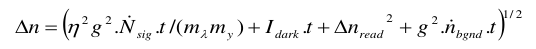
but to me:

* This is a rather crude way of taking into account line width and spectral PSF in the $λ$ direction, and the PSF in the $y$ direction.
* This does not take into account the fact that the source is extended: the signal lost to the neighboring pixels in the $y$ direction is (on average) recovered from the signal that should have gone to these neighboring pixels.
* Binning is difficult to take into account in this way.

## How `spice_uncertainties` works

Project [on IAS Gitlab](https://git.ias.u-psud.fr/spice/spice_uncertainties).

* From L2 FITS file:
    * Get study parameters
    * Get RADCAL calibration factor TODO check dependence on pixel
    * Get L2 data: spectral irradiance
* Convert values to L1 (DNs): multiply by RADCAL (optional: apply an offset)
* Consider these values to be the summed DNs in the superpixels
* Compute dark current and background signal
* Compute uncertainties on the dark current and on the background signal, and coming from the read noise and the photon noise on the signal.
* RSS these terms to get a total uncertainty
* Convert back to L2 values

Special treatment of negative signal values:

* set to 0 for the purpose of computing the photon noise
* the total uncertainty is set the the absolute value of the signal plus all the constant noises, to ensure that even large negative values are compatible with what would be the fitted spectral line.

## Pre-requisites

In a shell:
```sh
# Get the source code
git clone https://git.ias.u-psud.fr/spice/spice_uncertainties.git
cd spice_uncertainties
# It is advised to run in a virtual environment, e.g.
python -m venv .venv
. .venv/bin/activate
# Install dependencies and the package
python -m pip install -r requirements.txt .
```

How to run in the venv from a Jupyter notebook? I have found something like
```sh
python -m pip install ipykernel
python -m ipykernel install --name=.venv
```
and then one can create a notebook in the venv, but not sure exactly whether it works as intended.

## Computing uncertainties from a L2 file

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits

from spice_uncertainties import spice_error

In [2]:
# path to SPICE archive
spice_data_path = Path('/home/eric/observations/SO/SPICE/')

In [3]:
filepath = spice_data_path / 'fits/level2/2022/04/02/solo_L2_spice-n-ras_20220402T141537_V06_100664005-000.fits'
hdu_index = 2  # HDU 2 is Ne VIII for this file

In [4]:
with fits.open(filepath) as hdulist:
    hdulist.info()
    hdu = hdulist[hdu_index]
    data = hdu.data * u.W / u.m**2 / u.sr / u.nm
    av_constant_noise_level, sigma = spice_error(hdu)

Filename: /home/eric/observations/SO/SPICE/fits/level2/2022/04/02/solo_L2_spice-n-ras_20220402T141537_V06_100664005-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Mg IX 706 - Peak    1 PrimaryHDU     385   (160, 830, 50, 1)   float32   
  1  N IV 765 - Peak    1 ImageHDU       386   (160, 830, 50, 1)   float32   
  2  Ne VIII 770 - Peak    1 ImageHDU       386   (160, 830, 50, 1)   float32   
  3  Ly-gamma-CIII group (Merged)    1 ImageHDU       392   (160, 830, 64, 1)   float32   
  4  Ly Beta 1025 (Merged)    1 ImageHDU       392   (160, 830, 62, 1)   float32   
  5  O VI 1032 - Peak    1 ImageHDU       386   (160, 830, 34, 1)   float32   
  6  VARIABLE_KEYWORDS    1 BinTableHDU    383   1R x 27C   [160D, 160I, 160I, 160I, 160I, 160I, 160E, 160E, 160E, 160E, 5I, 5I, 5I, 5I, 5J, 5J, 5J, 5J, 3680A, 160D, 160D, 50D, 50D, 50D, 64D, 62D, 34D]   
  7  WCSDVARR      1 ImageHDU        26   (160,)   float64   
  8  WCSDVARR      2 ImageHDU        26   (160,)   flo

In [5]:
# Average contribution of noise to measured signal
av_constant_noise_level

<Quantity 0.04295139 W / (m2 nm pix sr)>

In [6]:
# Noise standard deviations for the different components (and total)
sigma

{'Dark': <Quantity 0.02036091 W / (m2 nm pix sr)>,
 'Background': <Quantity 0. W / (m2 nm pix sr)>,
 'Read': <Quantity 0.06659879 W / (m2 nm pix sr)>,
 'Signal': <Quantity [[[[nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              ...,
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan]],
 
             [[nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              ...,
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan]],
 
             [[nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              [nan, nan, nan, ..., nan, nan, nan],
              ...,
           

In [7]:
ix = 50 # raster position index to display

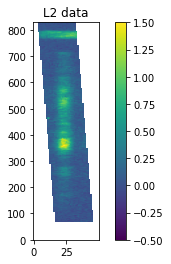

In [8]:
im = plt.imshow(data[0, :, :, ix].value.T, origin='lower', aspect=.2, vmin=-.5, vmax=1.5)
plt.title('L2 data')
plt.colorbar(im)

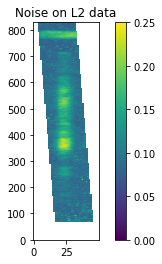

In [9]:
im = plt.imshow(sigma['Total'][0, :, :, ix].value.T, origin='lower', aspect=.2, vmin=0, vmax=.25)
plt.title('Noise on L2 data')
plt.colorbar(im)

Text(0, 0.5, 'Noise on L2 data')

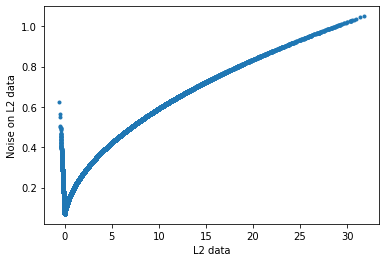

In [10]:
plt.scatter(data[0, ...], sigma['Total'][0, ...], marker='.')
plt.xlabel('L2 data')
plt.ylabel('Noise on L2 data')

Note: this looks nice only because it is directly computed from noise modelling (nothing random here).

## Open questions


This is still imperfect:

* The instrument parameters (and time dependence) are not well known yet
* Effect of dark current subtraction on noise (the dark map is noisy)
* What is the true distribution of the dark current?
* Do we need a background level estimate (and corresponding noise)
* Not sure I got everything right about gains (MCP...)
* Compare with uncertainties computed from Hardi's IDL code
* FLuctuating offset? (as in EUI APS)
* Need to remove contributions from dark current... from signal before computing noise?
* ...